In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as sk
from skfuzzy import control as ctrl
%matplotlib inline

In [2]:
from skfuzzy import interp_membership, interp_universe, defuzz
class CrispValueCalculator(object):
    """
    Convert a calculated FuzzyVariable back into a crisp real number.
 
    Parameters
    ----------
    fuzzy_var : FuzzyVariable
        The fuzzy variable to be defuzzified.
    sim : ControlSystemSimulation
        The simulation which holds all necessary data for this calculation.
    """
 
    def __init__(self, fuzzy_var, sim):
        """
        Initialization method for CrispValueCalculator.
        """ + '\n'.join(CrispValueCalculator.__doc__.split('\n')[1:])
        self.var = fuzzy_var
        self.sim = sim
 
    def defuzz(self):
        """Derive crisp value based on membership of adjective(s)."""
        ups_universe, output_mf, cut_mfs = self.find_memberships()
 
        if len(cut_mfs) == 0:
            raise ValueError("No terms have memberships.  Make sure you "
                             "have at least one rule connected to this "
                             "variable and have run the rules calculation.")
 
        try:
            return defuzz(ups_universe, output_mf,
                          self.var.defuzzify_method)
        except AssertionError:
            raise ValueError("Crisp output cannot be calculated, likely "
                             "because the system is too sparse. Check to "
                             "make sure this set of input values will "
                             "activate at least one connected Term in each "
                             "Antecedent via the current set of Rules.")
 
    def fuzz(self, value):
        """
        Propagate crisp value down to adjectives by calculating membership.
        """
        if len(self.var.terms) == 0:
            raise ValueError("Set Term membership function(s) first")
 
        for label, term in self.var.terms.items():
            term.membership_value[self.sim] = \
                interp_membership(self.var.universe, term.mf, value)
 
    def find_memberships(self):
        # Check we have some adjectives
        if len(self.var.terms.keys()) == 0:
            raise ValueError("Set term membership function(s) first")
 
        '''
        First we have to upsample the universe of self.var in order to add the
        key points of the membership function based on the activation level
        for this consequent, using the interp_universe function, which
        interpolates the `xx` values in the universe such that its membership
        function value is the activation level.
        '''
        add_universe = set()
        for label, term in self.var.terms.items():
            cut = term.membership_value[self.sim]
            if cut is None:
                continue  # No membership defined for this adjective
            add_xx = interp_universe(self.var.universe, term.mf, cut)
            add_universe.update(add_xx)
 
        # We are only interested in points not in self.var.universe
        add_universe = add_universe - set(self.var.universe)
 
        # We want to sort the universe values and keep related their indices
        # to access to their mf values
        upsampled_universe = (
            list(zip(self.var.universe.tolist() + list(add_universe),
                     list(range(self.var.universe.size)) + [None] * len(add_universe))))
 
        upsampled_universe.sort(key=lambda element: element[0])
        upsampled_mf_indices = [element[1] for element in upsampled_universe]
        upsampled_universe = np.array([
            element[0] for element in upsampled_universe])
 
        # Initilize membership
        output_mf = np.zeros_like(upsampled_universe, dtype=np.float64)
 
        # Build output membership function
        term_mfs = {}
        for label, term in self.var.terms.items():
            cut = term.membership_value[self.sim]
 
            if cut is None:
                continue  # No membership defined for this adjective
 
            upsampled_mf = []
            for i in range(len(upsampled_mf_indices)):
                if upsampled_mf_indices[i] is not None:
                    upsampled_mf.append(term.mf[upsampled_mf_indices[i]])
                else:
                    upsampled_mf.append(
                        interp_membership(self.var.universe, term.mf,
                                          upsampled_universe[i]))
 
            term_mfs[label] = np.minimum(cut, upsampled_mf)
            np.maximum(output_mf, term_mfs[label], output_mf)
 
        return upsampled_universe, output_mf, term_mfs

def print_st(s):
    """
    Print info about the inner workings of a ControlSystemSimulation.
    """
    print("=============");
    print(" Antecedents ");
    print("=============");
    for v in s.ctrl.antecedents:
        print(str(v) + " = " + str(v.input[s]));
        for term in v.terms.values():
            print("  - {0:32}: {1}".format(term.label,
                                            term.membership_value[s]))
    print("");
    print("=======");
    print(" Rules ");
    print("=======");
    rule_number = {}
    for rn, r in enumerate(s.ctrl.rules):
        rule_number[r] = "RULE #%d" % rn
        print("RULE #%d:\n  %s\n" % (rn, r))
        print("  Aggregation (IF-clause):")
        for term in r.antecedent_terms:
            print("   - {0:55}: {1}".format(term.full_label,
                                            term.membership_value[s]))        
        print("   " + str(r.antecedent) + " = " + str(r.aggregate_firing[s]))

        print("  Activation (THEN-clause):")
        for c in r.consequent:
            print("   " + str(c) + " : " + str(c.activation[s]))
        print("");
    print("");

    print("==============================");
    print(" Intermediaries and Conquests ");
    print("==============================");
    for c in s.ctrl.consequents:
        print(str(c) + " = " + str(CrispValueCalculator(c, s).defuzz()))

In [3]:
dirt=ctrl.Antecedent(np.arange(0,100,1),"DIRT")
grease=ctrl.Antecedent(np.arange(0,100,1),"GREASE")
washTime=ctrl.Consequent(np.arange(0,60,1),"Req_TIME")
washTime.defuzzify_method='mom'

In [4]:
dirt['vld']=sk.trimf(dirt.universe,[0,0,30])
dirt['ld']=sk.trimf(dirt.universe,[0,30,60])
dirt['ad']=sk.trimf(dirt.universe,[30,60,100])
dirt['hd']=sk.trimf(dirt.universe,[60,100,100])

In [5]:
grease['vlg']=sk.trimf(grease.universe,[0,0,30])
grease['lg']=sk.trimf(grease.universe,[0,30,60])
grease['ag']=sk.trimf(grease.universe,[30,60,100])
grease['hg']=sk.trimf(grease.universe,[60,100,100])

In [6]:
washTime['vlt']=sk.trimf(washTime.universe,[0,0,10])
washTime['lt']=sk.trimf(washTime.universe,[0,10,25])
washTime['at']=sk.trimf(washTime.universe,[10,25,40])
washTime['ht']=sk.trimf(washTime.universe,[25,40,60])
washTime['vht']=sk.trimf(washTime.universe,[40,60,60])

In [7]:
rule1=ctrl.Rule(dirt['vld'] & grease['vlg'],washTime['vlt'])
rule2=ctrl.Rule(dirt['vld'] & grease['lg'],washTime['lt'])
rule3=ctrl.Rule(dirt['vld'] & grease['ag'],washTime['at'])
rule4=ctrl.Rule(dirt['vld'] & grease['hg'],washTime['ht'])

rule5=ctrl.Rule(dirt['ld'] & grease['vlg'],washTime['lt'])
rule6=ctrl.Rule(dirt['ld'] & grease['lg'],washTime['lt'])
rule7=ctrl.Rule(dirt['ld'] & grease['ag'],washTime['at'])
rule8=ctrl.Rule(dirt['ld'] & grease['hg'],washTime['ht'])

rule9=ctrl.Rule(dirt['ad'] & grease['vlg'],washTime['lt'])
rule10=ctrl.Rule(dirt['ad'] & grease['lg'],washTime['lt'])
rule11=ctrl.Rule(dirt['ad'] & grease['ag'],washTime['at'])
rule12=ctrl.Rule(dirt['ad'] & grease['hg'],washTime['ht'])

rule13=ctrl.Rule(dirt['hd'] & grease['vlg'],washTime['at'])
rule14=ctrl.Rule(dirt['hd'] & grease['lg'],washTime['at'])
rule15=ctrl.Rule(dirt['hd'] & grease['ag'],washTime['ht'])
rule16=ctrl.Rule(dirt['hd'] & grease['hg'],washTime['vht'])

In [8]:
washController=sk.control.ControlSystem([rule1,rule2,rule3,rule4,rule5,rule6,rule7,rule8,rule9,rule10,rule11,rule12,rule13,rule14,rule15,rule16])
machne=sk.control.ControlSystemSimulation(washController)

In [9]:
machne.input['DIRT'],machne.input['GREASE']=40,30
machne.compute()
print(machne.output['Req_TIME'])

10.566666666666666


In [10]:
machne.input['DIRT'],machne.input['GREASE']=49,45
machne.compute()
print(machne.output['Req_TIME'])

18.933333333333334


In [11]:
machne.input['DIRT'],machne.input['GREASE']=85,93
machne.compute()
#print_st(machne)
print(machne.output['Req_TIME'])

55.5625


C:\ProgramData\Anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\ProgramData\Anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\ProgramData\Anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\ProgramData\Anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


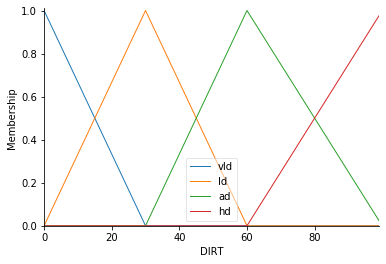

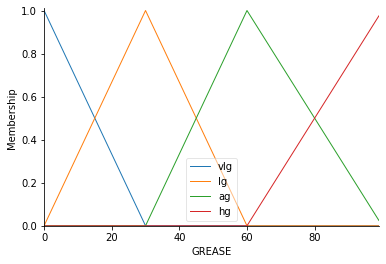

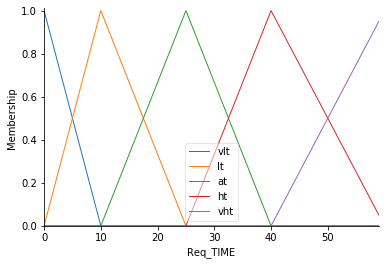

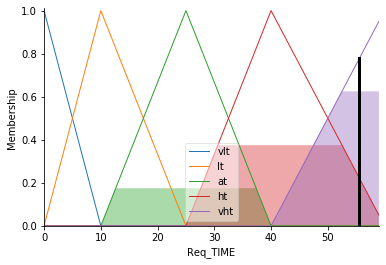

In [12]:
dirt.view()
grease.view()
washTime.view()
washTime.view(sim=machne)